# Imports

In [1]:
!pip install kaggle

In [2]:
import os
import glob
import torch
import random
import zipfile
import logging
import numpy as np
import pandas as pd
from PIL import Image
import torch.nn as nn
import seaborn as sns
import tensorflow as tf
from shutil import copyfile
import torch.optim as optim
from google.colab import files
from collections import Counter
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from collections import defaultdict
from torch.utils.data import Dataset
from tensorflow.keras.models import Model
from sklearn.model_selection import KFold
from tensorflow.keras import layers, models
import torchvision.transforms as transforms
from torchvision import datasets, transforms
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, Subset
from sklearn.preprocessing import StandardScaler
from concurrent.futures import ThreadPoolExecutor
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

logging.basicConfig(level=logging.INFO)



In [3]:
files.upload()

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c bgu-i-cant-see-you-but-you-are-reading-a-book
with zipfile.ZipFile("/content/bgu-i-cant-see-you-but-you-are-reading-a-book.zip", "r") as zip_ref:
    zip_ref.extractall("i_cant_see")

Saving kaggle.json to kaggle.json
100% 4.98G/4.98G [01:11<00:00, 98.3MB/s]
100% 4.98G/4.98G [01:11<00:00, 74.5MB/s]


In [4]:
df_train = pd.read_csv('/content/i_cant_see/train.csv')

In [5]:
df_metadata = pd.read_csv('/content/metadata.csv')

# Creating different data sets for smart watch and vicon

In [6]:
df_train_copy = df_train.copy()
df_train_smartwatch_copy = df_train_copy[ ~(df_train_copy['sensor']=='vicon')]
df_train_vicon_copy = df_train_copy[ ~(df_train_copy['sensor']=='smartwatch')]

In [7]:
("len of vicon:",len(df_train_vicon_copy),"len of smarwatch:" ,len(df_train_smartwatch_copy))

('len of vicon:', 14062, 'len of smarwatch:', 36186)

# Creating dictionaries for modeling the data

In [ ]:
#user -> actviti -> sensor -> body_part -> side ->sequence_length
user_activity_sensor_bodypart_side_sequence_length_dict = {
    (userid, activity, sensor, body_part, side, sequence_length): df_train[
        (df_train['userid'] == userid) &
        (df_train['activity'] == activity) &
        (df_train['sensor'] == sensor) &
        (df_train['body_part'] == body_part) &
        (df_train['side'] == side) &
        (df_train['sequence_length'] == sequence_length)
    ]
    for userid in df_train['userid'].unique()
    for activity in df_train[df_train['userid'] == userid]['activity'].unique()
    for sensor in df_train[
        (df_train['userid'] == userid) &
        (df_train['activity'] == activity)
    ]['sensor'].unique()
    for body_part in df_train[
        (df_train['userid'] == userid) &
        (df_train['activity'] == activity) &
        (df_train['sensor'] == sensor)
    ]['body_part'].unique()
    for side in df_train[
        (df_train['userid'] == userid) &
        (df_train['activity'] == activity) &
        (df_train['sensor'] == sensor) &
        (df_train['body_part'] == body_part)
    ]['side'].unique()
    for sequence_length in df_train[
        (df_train['userid'] == userid) &
        (df_train['activity'] == activity) &
        (df_train['sensor'] == sensor) &
        (df_train['body_part'] == body_part) &
        (df_train['side'] == side)
    ]['sequence_length'].unique()
}

In [8]:
user_activity_smartwatch_bodypart_side_dict = {
    (userid, activity, sensor, body_part, side): df_train_smartwatch_copy[
        (df_train_smartwatch_copy['userid'] == userid) &
        (df_train_smartwatch_copy['activity'] == activity) &
        (df_train_smartwatch_copy['sensor'] == sensor) &
        (df_train_smartwatch_copy['body_part'] == body_part) &
        (df_train_smartwatch_copy['side'] == side)
    ]
    for userid in df_train_smartwatch_copy['userid'].unique()
    for activity in df_train_smartwatch_copy[df_train_smartwatch_copy['userid'] == userid]['activity'].unique()
    for sensor in df_train_smartwatch_copy[(df_train_smartwatch_copy['userid'] == userid) & (df_train_smartwatch_copy['activity'] == activity)]['sensor'].unique()
    for body_part in df_train_smartwatch_copy[
        (df_train_smartwatch_copy['userid'] == userid) &
        (df_train_smartwatch_copy['activity'] == activity) &
        (df_train_smartwatch_copy['sensor'] == sensor)
    ]['body_part'].unique()
    for side in df_train_smartwatch_copy[
        (df_train_smartwatch_copy['userid'] == userid) &
        (df_train_smartwatch_copy['activity'] == activity) &
        (df_train_smartwatch_copy['sensor'] == sensor) &
        (df_train_smartwatch_copy['body_part'] == body_part)
    ]['side'].unique()
}



user_activity_vicon_bodypart_side_dict = {
    (userid, activity, sensor, body_part, side): df_train_vicon_copy[
        (df_train_vicon_copy['userid'] == userid) &
        (df_train_vicon_copy['activity'] == activity) &
        (df_train_vicon_copy['sensor'] == sensor) &
        (df_train_vicon_copy['body_part'] == body_part) &
        (df_train_vicon_copy['side'] == side)
    ]
    for userid in df_train_vicon_copy['userid'].unique()
    for activity in df_train_vicon_copy[df_train_vicon_copy['userid'] == userid]['activity'].unique()
    for sensor in df_train_vicon_copy[(df_train_vicon_copy['userid'] == userid) & (df_train_vicon_copy['activity'] == activity)]['sensor'].unique()
    for body_part in df_train_vicon_copy[
        (df_train_vicon_copy['userid'] == userid) &
        (df_train_vicon_copy['activity'] == activity) &
        (df_train_vicon_copy['sensor'] == sensor)
    ]['body_part'].unique()
    for side in df_train_vicon_copy[
        (df_train_vicon_copy['userid'] == userid) &
        (df_train_vicon_copy['activity'] == activity) &
        (df_train_vicon_copy['sensor'] == sensor) &
        (df_train_vicon_copy['body_part'] == body_part)
    ]['side'].unique()
}


# Train and Validation

## For smart watch

In [9]:
def sample_from_dict(data_dict, sample_ratio):
    if not 0 <= sample_ratio <= 1:
        raise ValueError("sample_ratio must be between 0 and 1")

    sampled_dict = {}

    for key, df in data_dict.items():
        if len(df) > 0:
            sampled_dict[key] = df.sample(frac=sample_ratio, random_state=42)
        else:
            sampled_dict[key] = df
    return sampled_dict

sample_ratio = 0.2
val_smartwatch_dict = sample_from_dict(user_activity_smartwatch_bodypart_side_dict, sample_ratio)


def remove_sampled_data(data_dict, sampled_dict):
    remaining_dict = {}

    for key, df in data_dict.items():
        sampled_rows = sampled_dict[key]
        remaining_dict[key] = df.drop(sampled_rows.index)

    return remaining_dict

train_smartwatch_dict = remove_sampled_data(user_activity_smartwatch_bodypart_side_dict, val_smartwatch_dict)


def combine_dict_to_dataframe(data_dict, shuffle_data=True):
    combined_df = pd.concat(data_dict.values(), ignore_index=True)
    if shuffle_data:
        combined_df = shuffle(combined_df, random_state=42).reset_index(drop=True)
    return combined_df

print(f"all DataFrame shape: {df_train_smartwatch_copy.shape}")

combined_train_smartwatch_df = combine_dict_to_dataframe(train_smartwatch_dict)

print(f"Combined DataFrame shape: {combined_train_smartwatch_df.shape}")
print(combined_train_smartwatch_df.head())

combined_val_smartwatch_df = combine_dict_to_dataframe(val_smartwatch_dict)
print(f"Combined DataFrame shape: {combined_val_smartwatch_df.shape}")
print(combined_val_smartwatch_df.head())

all DataFrame shape: (36186, 8)
Combined DataFrame shape: (28957, 8)
   Unnamed: 0  userid                activity      sensor body_part   side  \
0        6075  user03             using_phone  smartwatch      hand  right   
1       11485  user06            reading_book  smartwatch      hand   left   
2       38576  user05            reading_book  smartwatch      hand  right   
3       17021  user05      preparing_sandwich  smartwatch      hand   left   
4        3954  user05  walking_holding_a_tray  smartwatch      hand   left   

      id  sequence_length  
0  23494             3500  
1  51257             4000  
2  42111             3500  
3  41496             4000  
4  45200             3500  
Combined DataFrame shape: (7229, 8)
   Unnamed: 0  userid              activity      sensor body_part   side  \
0        7240  user02                  idle  smartwatch      hand   left   
1        4395  user04          reading_book  smartwatch      hand  right   
2       32712  user05        w

## For vicon

In [10]:
def sample_from_dict(data_dict, sample_ratio):
    if not 0 <= sample_ratio <= 1:
        raise ValueError("sample_ratio must be between 0 and 1")

    sampled_dict = {}

    for key, df in data_dict.items():
        if len(df) > 0:
            sampled_dict[key] = df.sample(frac=sample_ratio, random_state=42)
        else:
            sampled_dict[key] = df
    return sampled_dict

sample_ratio = 0.2
val_vicon_dict = sample_from_dict(user_activity_vicon_bodypart_side_dict, sample_ratio)


def remove_sampled_data(data_dict, sampled_dict):
    remaining_dict = {}

    for key, df in data_dict.items():
        sampled_rows = sampled_dict[key]
        remaining_dict[key] = df.drop(sampled_rows.index)

    return remaining_dict

train_vicon_dict = remove_sampled_data(user_activity_vicon_bodypart_side_dict, val_vicon_dict)


def combine_dict_to_dataframe(data_dict, shuffle_data=True):
    combined_df = pd.concat(data_dict.values(), ignore_index=True)
    if shuffle_data:
        combined_df = shuffle(combined_df, random_state=42).reset_index(drop=True)
    return combined_df

print(f"all DataFrame shape: {df_train_vicon_copy.shape}")

combined_train_vicon_df = combine_dict_to_dataframe(train_vicon_dict)

print(f"Combined DataFrame shape: {combined_train_vicon_df.shape}")
print(combined_train_vicon_df.head())

combined_val_vicon_df = combine_dict_to_dataframe(val_vicon_dict)
print(f"Combined DataFrame shape: {combined_val_vicon_df.shape}")
print(combined_val_vicon_df.head())

all DataFrame shape: (14062, 8)
Combined DataFrame shape: (11254, 8)
   Unnamed: 0  userid                      activity sensor body_part   side  \
0       44144  user08  walking_with_object_underarm  vicon      foot   left   
1       46658  user03          using_remote_control  vicon      hand   left   
2       31404  user07                  reading_book  vicon      hand  right   
3       28255  user01        walking_holding_a_tray  vicon      foot   left   
4        9628  user08        walking_holding_a_tray  vicon      foot   left   

      id  sequence_length  
0  75402             3000  
1  24407             4000  
2  60673             3500  
3   7268             3500  
4  72913             3500  
Combined DataFrame shape: (2808, 8)
   Unnamed: 0  userid              activity sensor body_part   side     id  \
0       14272  user03                  idle  vicon      hand  right  21647   
1       27637  user05    preparing_sandwich  vicon      foot   left  41738   
2       40845  use

# SensorDataLoader
A Feature factor is generated, the structure is a list, where each position has a dictionary value with the data from the corresponding sensor and the type of the labeled activity.

In [11]:
class SensorDataLoader:
    def __init__(self, data_dir):
        self.data_dir = data_dir

    def load_vicon_data(self, file_path):
        """Load Vicon sensor data from a file."""
        try:
            data = pd.read_csv(file_path, header=None, names=['x', 'y', 'z'], skiprows=1)
            return data
        except FileNotFoundError:
            print(f"File {file_path} not found.")
            return None

    def load_smartwatch_data(self, file_path):
        """Load Smartwatch sensor data from a file."""
        try:
            data = pd.read_csv(file_path, header=None, names=['measurement_type', 'x', 'y', 'z'], skiprows=1)
            grouped_data = {group: df.drop(columns=['measurement_type']) for group, df in data.groupby('measurement_type')}
            # print(grouped_data)
            return grouped_data
        except FileNotFoundError:
            print(f"File {file_path} not found.")
            return None

    def load_sensor_data(self, sensor_type, file_path):
        """Load sensor data based on sensor type."""
        if sensor_type == 'vicon':
            return {'vicon': self.load_vicon_data(file_path)}
        elif sensor_type == 'smartwatch':
            return self.load_smartwatch_data(file_path)
        else:
            raise ValueError(f"Unknown sensor type: {sensor_type}")

    def verify_files(self, table):
        """Verify that all expected files exist in the data directory."""
        missing_files = []
        for _, row in table.iterrows():
            file_path = os.path.join(self.data_dir, f"{row['id']}.csv")
            if not os.path.exists(file_path):
                missing_files.append(file_path)
        if missing_files:
            print(f"Missing files: {missing_files}")
        return len(missing_files) == 0

    def load_data_for_table(self, table, data_type='train'):
        """Load data for a given table sequentially."""
        if data_type not in ['train', 'val']:
            raise ValueError("data_type must be either 'train' or 'val'")

        data_list = []
        for _, row in table.iterrows():
            file_path = os.path.join(self.data_dir, f"{row['id']}.csv")
            sensor_data = self.load_sensor_data(row['sensor'], file_path)

            if sensor_data is not None:
                data_list.append({
                    'sensor_data': sensor_data,
                    'label': row['activity'],
                    'sequence_length': row['sequence_length'],
                })

        return data_list

    def load_data_for_table_parallel(self, table, data_type='train'):
        """Load data for a given table in parallel."""
        if data_type not in ['train', 'val']:
            raise ValueError("data_type must be either 'train' or 'val'")

        def process_row(row):
            file_path = os.path.join(self.data_dir, f"{row['id']}.csv")
            sensor_data = self.load_sensor_data(row['sensor'], file_path)
            if sensor_data is not None:
                return {
                    'sensor_data': sensor_data,
                    'label': row['activity'],
                    'sequence_length': row['sequence_length'],
                }
            return None

        with ThreadPoolExecutor() as executor:
            results = executor.map(process_row, [row for _, row in table.iterrows()])
            return list(filter(None, results))





## For smart watch

In [12]:
data_dir = '/content/i_cant_see/unlabeled/unlabeled'
sensor_loader = SensorDataLoader(data_dir)

train_smartwatch_data = sensor_loader.load_data_for_table(combined_train_smartwatch_df, data_type='train')

val_smartwatch_data = sensor_loader.load_data_for_table(combined_val_smartwatch_df , data_type='val')

print(train_smartwatch_data[0])
print(val_smartwatch_data[0])


{'sensor_data': {'acceleration [m/s/s]':               x         y         z
0     -7.932523  2.283533  2.551620
3     -7.741032  2.408002  2.723962
6     -7.702734  2.398427  2.858006
9     -7.702734  2.398427  2.858006
12    -7.884651  2.312256  3.059072
...         ...       ...       ...
3487 -10.488931  2.283533  3.499502
3490 -10.575102  2.360129  3.020774
3493  -9.981480  2.139914  1.986721
3496  -9.387856  1.957998  1.555866
3499  -8.832532  1.881401  1.163309

[1170 rows x 3 columns], 'gyroscope [rad/s]':              x         y         z
2     1.030725 -0.039951 -0.636546
5     0.980121  0.013317 -0.567298
8     0.913537  0.058594 -0.514031
11    0.836299  0.093218 -0.482070
14    0.756398  0.114525 -0.463427
...        ...       ...       ...
3486 -0.972131  0.388852 -0.255684
3489 -0.937507  0.383526 -0.229050
3492 -0.956151  0.351565 -0.141159
3495 -1.017408  0.300961 -0.013317
3498 -1.086656  0.231713  0.125179

[1165 rows x 3 columns], 'magnetometer [uT]':             x

## For vicon

In [13]:
train_vicon_data = sensor_loader.load_data_for_table(combined_train_vicon_df, data_type='train')

val_vicon_data = sensor_loader.load_data_for_table(combined_val_vicon_df , data_type='val')
print(train_vicon_data[0])
print(val_vicon_data[0])


{'sensor_data': {'vicon':              x         y         z
0    -0.359392 -1.974425  1.045469
1    -0.351116 -1.976025  1.044670
2    -0.343008 -1.977774  1.044279
3    -0.334337 -1.979021  1.043593
4    -0.326266 -1.980704  1.043375
...        ...       ...       ...
2995  0.422537  0.819760  0.183043
2996  0.410084  0.824066  0.189163
2997  0.397826  0.831523  0.192652
2998  0.384146  0.838741  0.194764
2999  0.370930  0.847380  0.195294

[3000 rows x 3 columns]}, 'label': 'walking_with_object_underarm', 'sequence_length': 3000}
{'sensor_data': {'vicon':              x         y         z
0    -0.155005 -0.437468  0.880345
1    -0.154973 -0.437579  0.880419
2    -0.155001 -0.437666  0.880377
3    -0.154930 -0.437740  0.880392
4    -0.154824 -0.437760  0.880385
...        ...       ...       ...
3995 -0.113436 -0.471939  0.629123
3996 -0.113444 -0.471977  0.629132
3997 -0.113420 -0.471971  0.629119
3998 -0.113403 -0.471951  0.629086
3999 -0.113422 -0.472046  0.629059

[4000 rows x 3

# Test for class SensorDataLoader

In [ ]:
sensor_data_dict = {}

for data_entry in val_data:
    for measurement_type, sensor_df in data_entry['sensor_data'].items():
        if measurement_type not in sensor_data_dict:
            sensor_data_dict[measurement_type] = []

        sensor_data_dict[measurement_type].append(sensor_df)



#**DataPreprocessor**
* Data Normalization
* Found the Mean and Standard Deviation
* Connection to the Pietersz Vector

In [14]:
class DataPreprocessor:
    def __init__(self, maxlen):
        self.scaler = StandardScaler()
        self.maxlen = maxlen  # Fixed length for padding

    def handle_missing_data(self, data):
        """Fill missing data with zeros."""
        if data.isnull().sum().sum() > 0:
            print("Missing data detected:")
            print(data[data.isnull().any(axis=1)])
        return data.fillna(0)

    def extract_features(self, data):
        """Extract basic statistical features from sensor data."""
        features = {
            'mean_x': np.mean(data['x']),
            'std_x': np.std(data['x']),
            'mean_y': np.mean(data['y']),
            'std_y': np.std(data['y']),
            'mean_z': np.mean(data['z']),
            'std_z': np.std(data['z']),
        }
        return features

    def remove_outliers(self, data, threshold=3):
        """Remove outliers based on Z-score."""
        for col in ['x', 'y', 'z']:
            z_scores = (data[col] - data[col].mean()) / data[col].std()
            data = data[(z_scores < threshold) & (z_scores > -threshold)]
        return data

    def normalize_data(self, data):
        """Normalize sensor data."""
        return self.scaler.fit_transform(data[['x', 'y', 'z']])

    def pad_sequences(self, data_list, maxlen):
        """Pad sequences to a fixed length."""
        return pad_sequences(data_list, maxlen=maxlen, padding='post', dtype='float32')

    def pad_and_stack_data(self, sensor_data):
        """
        Normalize, pad, and stack data from multiple sensors.
        Returns a 3D tensor: [time_steps, features, sensors].
        """
        normalized_data_list = []
        for measurement_type, data in sensor_data.items():
            # Handle missing data, outliers, and normalize
            data = self.handle_missing_data(data)
            data = self.remove_outliers(data)
            normalized_data = self.normalize_data(data)

            # Pad the sequence and append
            padded_data = self.pad_sequences([normalized_data], maxlen=self.maxlen)
            normalized_data_list.append(padded_data[0])  # Remove batch dimension

        # Stack along the last axis (sensors as channels)
        return np.stack(normalized_data_list, axis=-1)

    def preprocess_data(self, sensor_data, label, sequence_length=None):
        """
        Preprocess sensor data by handling missing data, extracting features,
        and normalizing the data for each measurement type separately.
        """
        processed_data = []
        for measurement_type, data in sensor_data.items():
            data = self.handle_missing_data(data)
            features = self.extract_features(data)

            processed_data.append({
                'features': features,
            })

        # Pad and stack the data for model input
        padded_and_stacked_data = self.pad_and_stack_data(sensor_data)

        processed_data_dict = {
            'processed_data': processed_data,
            'padded_and_stacked_data': padded_and_stacked_data,
            'label': label,
            'sequence_length': sequence_length,
        }

        return processed_data_dict

    def window_data(self, data, window_size):
        """
        Split data into overlapping windows of size `window_size` and return the mean of each window for each axis (x, y, z).
        """
        windows = []
        means = []
        for start in range(0, len(data) - window_size + 1, window_size):
            window = data[start:start + window_size]

            # Calculate the mean for each axis (x, y, z)
            mean_x = np.mean(window[:, 0])  # mean of x values
            mean_y = np.mean(window[:, 1])  # mean of y values
            mean_z = np.mean(window[:, 2])  # mean of z values

            means.append([mean_x, mean_y, mean_z])  # Collect means as a vector

            windows.append(window)

        return np.array(windows), np.array(means)

    def batch_data(self, data, labels, batch_size):
        """
        Yield batches of data and labels.
        """
        batch_data = []
        batch_labels = []
        for i in range(len(data)):
            batch_data.append(data[i])
            batch_labels.append(labels[i])

            if len(batch_data) == batch_size:
                yield np.array(batch_data), np.array(batch_labels)
                batch_data, batch_labels = [], []

        if len(batch_data) > 0:
            yield np.array(batch_data), np.array(batch_labels)


## For smartwatch

In [15]:
X_smartwatch_train = []
y_smartwatch_train = []
X_smartwatch_val = []
y_smartwatch_val = []

maxlen = 3000
preprocessor = DataPreprocessor(maxlen)
for data_entry in train_smartwatch_data:
    sensor_data = data_entry['sensor_data']
    label = data_entry['label']
    sequence_length = data_entry['sequence_length']

    processed_data = preprocessor.preprocess_data(sensor_data, label, sequence_length)

    features = []
    for measurement_type, data in sensor_data.items():

        feature_vector = preprocessor.extract_features(data)
        features.extend(list(feature_vector.values()))

    if len(features) > 0:
        X_smartwatch_train.append(features)
        y_smartwatch_train.append(label)

for data_entry in val_smartwatch_data:
    sensor_data = data_entry['sensor_data']
    label = data_entry['label']
    sequence_length = data_entry['sequence_length']

    processed_data = preprocessor.preprocess_data(sensor_data, label, sequence_length)

    features = []
    for measurement_type, data in sensor_data.items():

        feature_vector = preprocessor.extract_features(data)
        features.extend(list(feature_vector.values()))

    if len(features) > 0:
        X_smartwatch_val.append(features)
        y_smartwatch_val.append(label)


## For  vicon

In [16]:
X_vicon_train = []
y_vicon_train = []
X_vicon_val = []
y_vicon_val = []

maxlen = 3000
preprocessor = DataPreprocessor(maxlen)
for data_entry in train_vicon_data:
    sensor_data = data_entry['sensor_data']
    label = data_entry['label']
    sequence_length = data_entry['sequence_length']

    processed_data = preprocessor.preprocess_data(sensor_data, label, sequence_length)

    features = []
    for measurement_type, data in sensor_data.items():

        feature_vector = preprocessor.extract_features(data)
        features.extend(list(feature_vector.values()))

    if len(features) > 0:
        X_vicon_train.append(features)
        y_vicon_train.append(label)

for data_entry in val_vicon_data:
    sensor_data = data_entry['sensor_data']
    label = data_entry['label']
    sequence_length = data_entry['sequence_length']

    processed_data = preprocessor.preprocess_data(sensor_data, label, sequence_length)

    features = []
    for measurement_type, data in sensor_data.items():

        feature_vector = preprocessor.extract_features(data)
        features.extend(list(feature_vector.values()))


    if len(features) > 0:
        X_vicon_val.append(features)
        y_vicon_val.append(label)

In [17]:
X_smartwatch_train = np.array(X_smartwatch_train, dtype=np.float32)
y_smartwatch_train = np.array(y_smartwatch_train)
X_smartwatch_val = np.array(X_smartwatch_val, dtype=np.float32)
y_smartwatch_val = np.array(y_smartwatch_val)

print("X_smartwatch_train shape:", X_smartwatch_train.shape)
print("y_smartwatch_train shape:", y_smartwatch_train.shape)
print("X_smartwatch_val shape:", X_smartwatch_val.shape)
print("y_smartwatch_val shape:", y_smartwatch_val.shape)
X_vicon_train = np.array(X_vicon_train, dtype=np.float32)
y_vicon_train = np.array(y_vicon_train)
X_vicon_val = np.array(X_vicon_val, dtype=np.float32)
y_vicon_val = np.array(y_vicon_val)

print("X_vicon_train shape:", X_vicon_train.shape)
print("y_vicon_train shape:", y_vicon_train.shape)
print("X_vicon_val shape:", X_vicon_val.shape)
print("y_vicon_val shape:", y_vicon_val.shape)

X_smartwatch_train shape: (28957, 18)
y_smartwatch_train shape: (28957,)
X_smartwatch_val shape: (7229, 18)
y_smartwatch_val shape: (7229,)
X_vicon_train shape: (11254, 6)
y_vicon_train shape: (11254,)
X_vicon_val shape: (2808, 6)
y_vicon_val shape: (2808,)


In [ ]:
X_train[0]

array([ 6.6497416e+00,  1.3625487e+00, -7.6195416e+00,  1.2552744e+00,
       -5.1697868e-01,  1.1700939e+00, -2.6494685e-01,  6.1013544e-01,
        2.8507161e-01,  6.8782520e-01,  1.2724409e-02,  2.6575714e-01,
       -2.5216427e+01,  6.2593575e+00,  3.5298238e+00,  6.1507978e+00,
        5.3960777e+01,  1.1435691e+01], dtype=float32)

# **2)**
## **b.**

# Two naive solutions

In [ ]:
def naive_last_known_value(df_train, df_val):
    last_known_activity = df_train.groupby('userid')['activity'].last()
    val_predictions = df_val['userid'].map(last_known_activity)
    accuracy = accuracy_score(df_val['activity'], val_predictions)
    return accuracy

def naive_class_distribution(df_train, df_val):
    class_distribution = df_train['activity'].value_counts(normalize=True)
    most_frequent_activity = class_distribution.idxmax()
    val_predictions = [most_frequent_activity] * len(df_val)
    accuracy = accuracy_score(df_val['activity'], val_predictions)
    return accuracy

last_known_accuracy = naive_last_known_value(combined_train_df, combined_val_df)
class_distribution_accuracy = naive_class_distribution(combined_train_df, combined_val_df)

print(f"Last Known Value Accuracy: {last_known_accuracy}")
print(f"Class Distribution Accuracy: {class_distribution_accuracy}")

# Solution according to the distribution of categories

In [ ]:
processed_train_data = []
processed_val_data = []

for i in range(len(X_train)):
    processed_train_data.append({
        'sensor_data': X_train[i],
        'label': y_train[i],
        'sequence_length': len(X_train[i])
    })

for i in range(len(X_val)):
    processed_val_data.append({
        'sensor_data': X_val[i],
        'label': y_val[i],
        'sequence_length': len(X_val[i])
    })


def naive_baseline_class_distribution(train_data, val_data):
    train_labels = [entry['label'] for entry in train_data]

    most_common_label = Counter(train_labels).most_common(1)[0][0]

    train_predictions = [most_common_label] * len(train_data)
    val_predictions = [most_common_label] * len(val_data)

    train_accuracy = accuracy_score(train_labels, train_predictions)
    val_labels = [entry['label'] for entry in val_data]
    val_accuracy = accuracy_score(val_labels, val_predictions)

    return train_accuracy, val_accuracy

train_accuracy, val_accuracy = naive_baseline_class_distribution(processed_train_data, processed_val_data)
print(f"Train accuracy: {train_accuracy}")
print(f"Validation accuracy: {val_accuracy}")


Train accuracy: 0.08267431018406603
Validation accuracy: 0.08258403651957394


#Last Observation Carried Forward (LOCF)

In [ ]:
def naive_baseline_random(train_data, val_data):
    train_labels = [entry['label'] for entry in train_data]

    unique, counts = np.unique(train_labels, return_counts=True)
    class_distribution = dict(zip(unique, counts))

    total_count = sum(counts)
    activity_probabilities = {activity: count / total_count for activity, count in class_distribution.items()}

    train_predictions = np.random.choice(list(activity_probabilities.keys()),
                                         size=len(train_labels),
                                         p=list(activity_probabilities.values()))

    val_labels = [entry['label'] for entry in val_data]
    val_predictions = np.random.choice(list(activity_probabilities.keys()),
                                       size=len(val_labels),
                                       p=list(activity_probabilities.values()))

    train_accuracy = accuracy_score(train_labels, train_predictions)
    val_accuracy = accuracy_score(val_labels, val_predictions)

    return train_accuracy, val_accuracy

train_accuracy, val_accuracy = naive_baseline_random(processed_train_data, processed_val_data)
print(f"Train accuracy: {train_accuracy}")
print(f"Validation accuracy: {val_accuracy}")


Train accuracy: 0.06212660151258763
Validation accuracy: 0.06280260063632591


# **2)**
## **c.**

# Benchmark

we used random forest

In [ ]:
model = RandomForestClassifier(n_estimators=100, random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {accuracy}")


Validation Accuracy: 0.7985969014907922


In [ ]:
print(classification_report(y_val, y_pred))

print(confusion_matrix(y_val, y_pred))

                               precision    recall  f1-score   support

               brushing_teeth       0.83      0.82      0.83       101
                         idle       0.85      0.82      0.83       185
           preparing_sandwich       0.81      0.82      0.81       149
                 reading_book       0.89      0.87      0.88       174
                  stairs_down       0.90      0.90      0.90        80
                    stairs_up       0.88      0.86      0.87        87
                       typing       0.89      0.89      0.89        84
                  using_phone       0.81      0.79      0.80       287
         using_remote_control       0.78      0.78      0.78       173
               walking_freely       0.74      0.80      0.77       313
       walking_holding_a_tray       0.84      0.86      0.85       298
         walking_with_handbag       0.76      0.79      0.78       303
walking_with_hands_in_pockets       0.83      0.82      0.83       288
 walk

# **2)**
## **d.**

#1D-CNN

In [ ]:
print(f"X_train shape after preprocessing: {X_train.shape}")
print(f"X_val shape after preprocessing: {X_val.shape}")

X_train shape after preprocessing: (13723, 6)
X_val shape after preprocessing: (3421, 6)


In [18]:
class SensorCNNModel:
    def __init__(self, sequence_length, num_features, num_classes):
        self.sequence_length = sequence_length
        self.num_features = num_features
        self.num_classes = num_classes
        self.model = self._create_model()

    def _create_model(self):
        model = models.Sequential()

        model.add(layers.InputLayer(input_shape=(self.num_features,)))
        model.add(layers.Dense(64, activation='relu'))
        model.add(layers.Dense(32, activation='relu'))
        model.add(layers.Dense(self.num_classes, activation='softmax'))

        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        return model


    def preprocess_data(self, X):
        """
        Flatten each data point from shape (100, 3, 3) to (100, 9)
        Reshape data to match the model's expected input shape (None, 100, 9)
        """
        return X

    def fit(self, X_train, y_train, X_val, y_val, epochs=10, batch_size=32):
        # Preprocess the data to match the model input
        X_train = self.preprocess_data(X_train)
        X_val = self.preprocess_data(X_val)

        # Fit the model
        history = self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val))

        return history

    def evaluate(self, X_val, y_val):
        X_val = self.preprocess_data(X_val)
        val_loss, val_acc = self.model.evaluate(X_val, y_val)
        print(f"Validation Accuracy: {val_acc}")
        return val_acc

    def predict(self, X):
        X = self.preprocess_data(X)
        predictions = self.model.predict(X)
        return predictions
    def confusion_matrix(self, X_val, y_val, class_names=None):

        y_pred = np.argmax(self.model.predict(X_val), axis=1)

        cm = confusion_matrix(y_val, y_pred)

        accuracy = accuracy_score(y_val, y_pred)
        total_predictions = cm.sum()
        correct_predictions = np.trace(cm)
        incorrect_predictions = total_predictions - correct_predictions

        print(f"Accuracy: {accuracy:.2%}")
        print(f"Correct Predictions: {correct_predictions}")
        print(f"Incorrect Predictions: {incorrect_predictions}")

        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted Labels")
        plt.ylabel("True Labels")
        plt.show()

        class_accuracy = cm.diagonal() / cm.sum(axis=1)

        sorted_indices = np.argsort(class_accuracy)[::-1]
        sorted_class_names = [class_names[i] for i in sorted_indices]
        sorted_class_accuracy = class_accuracy[sorted_indices]

        plt.figure(figsize=(12, 6))
        bars = plt.bar(sorted_class_names, sorted_class_accuracy * 100, color='skyblue')

        for bar, acc in zip(bars, sorted_class_accuracy):
            plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{acc * 100:.1f}%",
                    ha='center', va='bottom', fontsize=10)

        plt.title("Accuracy per Class")
        plt.ylabel("Accuracy (%)")
        plt.xlabel("Class")
        plt.xticks(rotation=45, ha='right')
        plt.ylim(0, 100)
        plt.tight_layout()
        plt.show()

        error_matrix = cm - np.diagflat(cm.diagonal())
        plt.figure(figsize=(10, 8))
        sns.heatmap(error_matrix, annot=True, fmt='d', cmap='Reds', xticklabels=class_names, yticklabels=class_names)
        plt.title("Error Matrix")
        plt.xlabel("Predicted Labels")
        plt.ylabel("True Labels")
        plt.show()

        return cm, accuracy, correct_predictions, incorrect_predictions

In [19]:
label_encoder = LabelEncoder()

y_smartwatch_train = label_encoder.fit_transform(y_smartwatch_train)
y_smartwatch_val = label_encoder.transform(y_smartwatch_val)
X_smartwatch_train = np.array(X_smartwatch_train, dtype=np.float32)
X_smartwatch_val = np.array(X_smartwatch_val, dtype=np.float32)
print("X_smartwatch_train dtype:", X_smartwatch_train.dtype)
print("y_smartwatch_train dtype:", y_smartwatch_train.dtype)
print("X_smartwatch_val dtype:", X_smartwatch_val.dtype)
print("y_smartwatch_val dtype:", y_smartwatch_val.dtype)
y_vicon_train = label_encoder.fit_transform(y_vicon_train)
y_vicon_val = label_encoder.transform(y_vicon_val)
X_vicon_train = np.array(X_vicon_train, dtype=np.float32)
X_vicon_val = np.array(X_vicon_val, dtype=np.float32)
print("X_vicon_train dtype:", X_vicon_train.dtype)
print("y_vicon_train dtype:", y_vicon_train.dtype)
print("X_vicon_val dtype:", X_vicon_val.dtype)
print("y_vicon_val dtype:", y_vicon_val.dtype)


X_smartwatch_train dtype: float32
y_smartwatch_train dtype: int64
X_smartwatch_val dtype: float32
y_smartwatch_val dtype: int64
X_vicon_train dtype: float32
y_vicon_train dtype: int64
X_vicon_val dtype: float32
y_vicon_val dtype: int64


In [ ]:
len(np.unique(y_train))

18

# For smartwatch

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/10
905/905 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.4116 - loss: 1.9388 - val_accuracy: 0.6355 - val_loss: 1.0463
Epoch 2/10
905/905 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6544 - loss: 0.9808 - val_accuracy: 0.7055 - val_loss: 0.8376
Epoch 3/10
905/905 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7211 - loss: 0.7897 - val_accuracy: 0.7312 - val_loss: 0.7374
Epoch 4/10
905/905 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7588 - loss: 0.6839 - val_accuracy: 0.7693 - val_loss: 0.6510
Epoch 5/10
905/905 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7809 - loss: 0.6153 - val_accuracy: 0.7767 - val_loss: 0.6234
Epoch 6/10
905/905 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7958 - loss: 0.5763 - val_accuracy: 0.8000 - val_loss: 0.5790
Epoch 7/10
905/905 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8038 - loss: 0.5432 - val_accuracy: 0.8181 - val_loss: 0.5243
Epoch 8/10
905/905 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8224 - loss: 0.4985 - val_accuracy: 0.

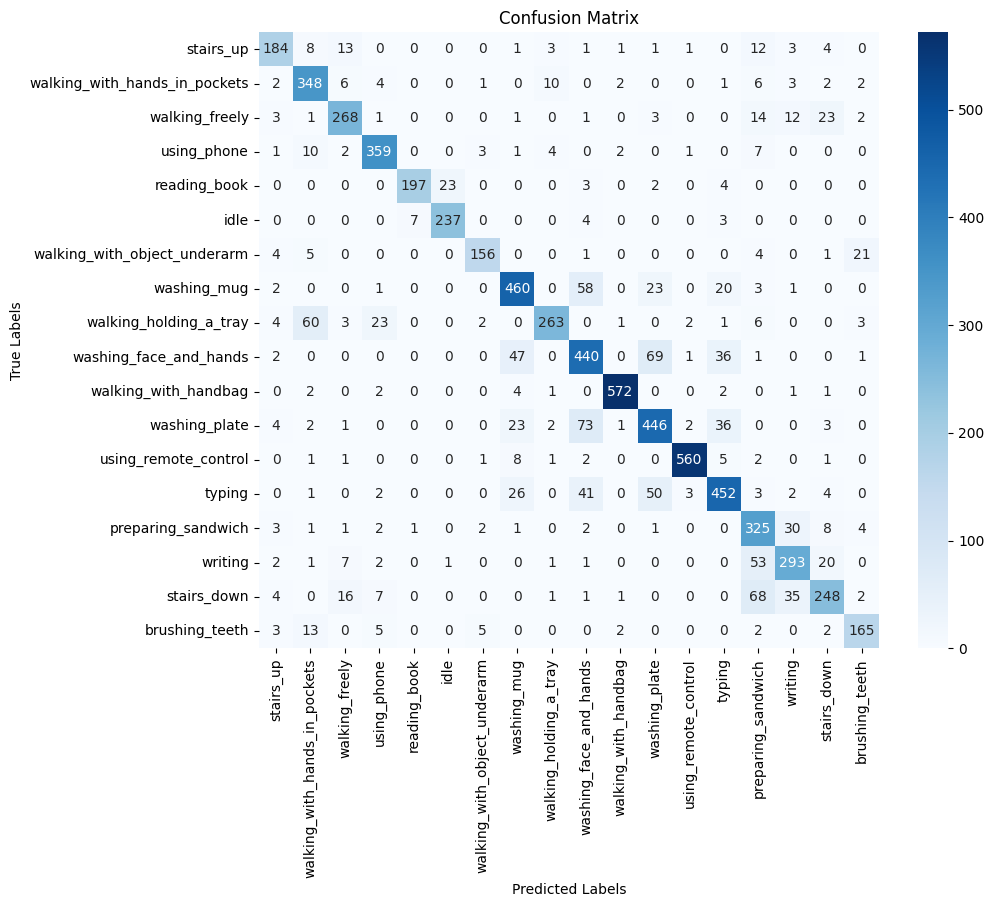

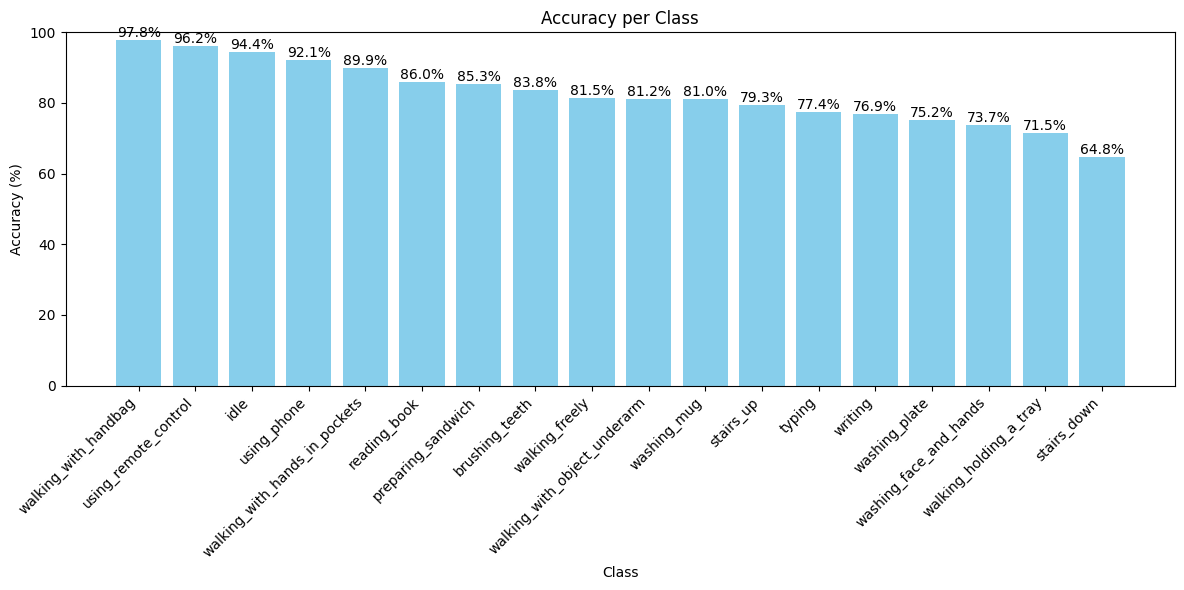

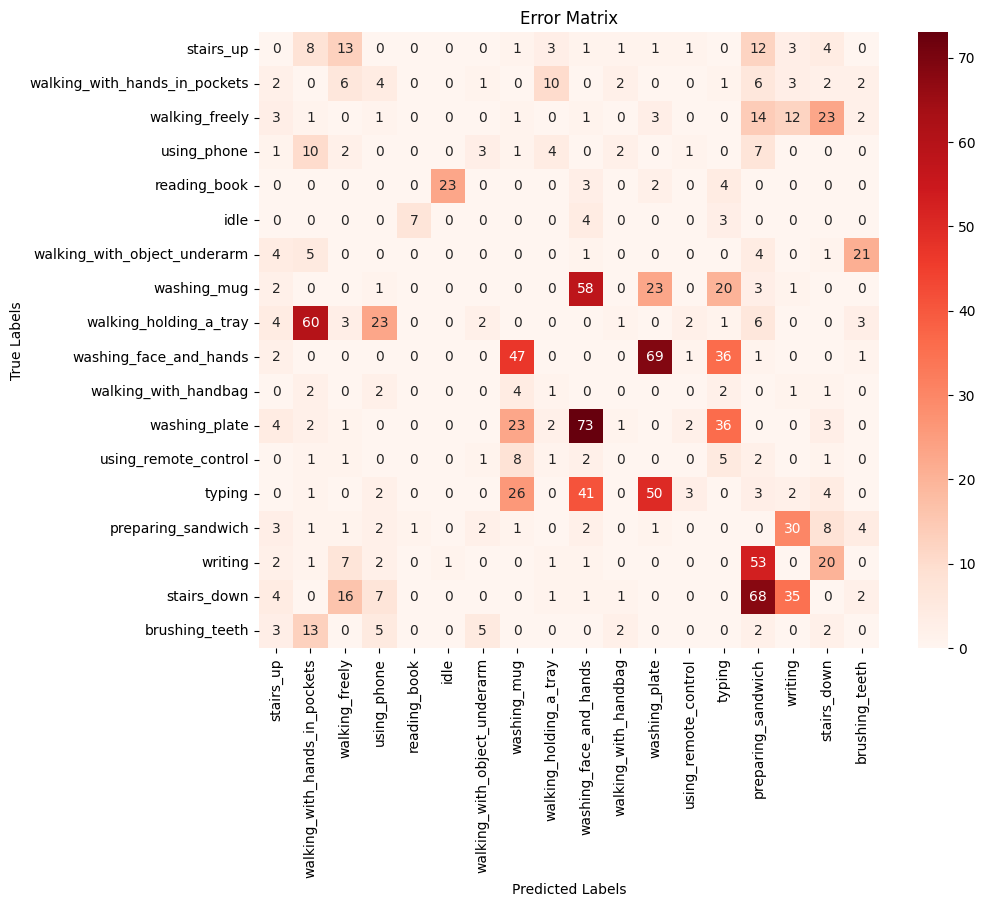

In [20]:
sequence_length = 300
num_features = 18
num_classes = len(np.unique(y_smartwatch_train))

cnn_smartwatch_model = SensorCNNModel(sequence_length, num_features, num_classes)

history = cnn_smartwatch_model.fit(X_smartwatch_train, y_smartwatch_train, X_val=X_smartwatch_val, y_val=y_smartwatch_val, epochs=10, batch_size=32)

val_smartwatch_accuracy = cnn_smartwatch_model.evaluate(X_smartwatch_val, y_smartwatch_val)
print(f"Validation Accuracy: {val_smartwatch_accuracy}")

predictions_smartwatch = cnn_smartwatch_model.predict(X_smartwatch_val)
print("Predictions for smartwatch:", predictions_smartwatch)

class_name = ['stairs_up','walking_with_hands_in_pockets', 'walking_freely', 'using_phone', 'reading_book', 'idle', 'walking_with_object_underarm', 'washing_mug', 'walking_holding_a_tray', 'washing_face_and_hands', 'walking_with_handbag', 'washing_plate', 'using_remote_control', 'typing', 'preparing_sandwich', 'writing', 'stairs_down', 'brushing_teeth']
cm = cnn_smartwatch_model.confusion_matrix(X_smartwatch_val, y_smartwatch_val, class_names=class_name)


# For vicon

In [22]:
num_classes = len(np.unique(y_vicon_train))
num_classes

16

Epoch 1/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.1427 - loss: 2.3483 - val_accuracy: 0.2005 - val_loss: 1.9397
Epoch 2/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2110 - loss: 1.9282 - val_accuracy: 0.2283 - val_loss: 1.8702
Epoch 3/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2379 - loss: 1.8549 - val_accuracy: 0.2568 - val_loss: 1.8102
Epoch 4/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2577 - loss: 1.8088 - val_accuracy: 0.2511 - val_loss: 1.7763
Epoch 5/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2501 - loss: 1.7856 - val_accuracy: 0.2621 - val_loss: 1.7618
Epoch 6/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2776 - loss: 1.7440 - val_accuracy: 0.2967 - val_loss: 1.7229
Epoch 7/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2932 - loss: 1.7224 - val_accuracy: 0.2842 - val_loss: 1.7071
Epoch 8/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2971 - loss: 1.6983 - val_accuracy: 0.

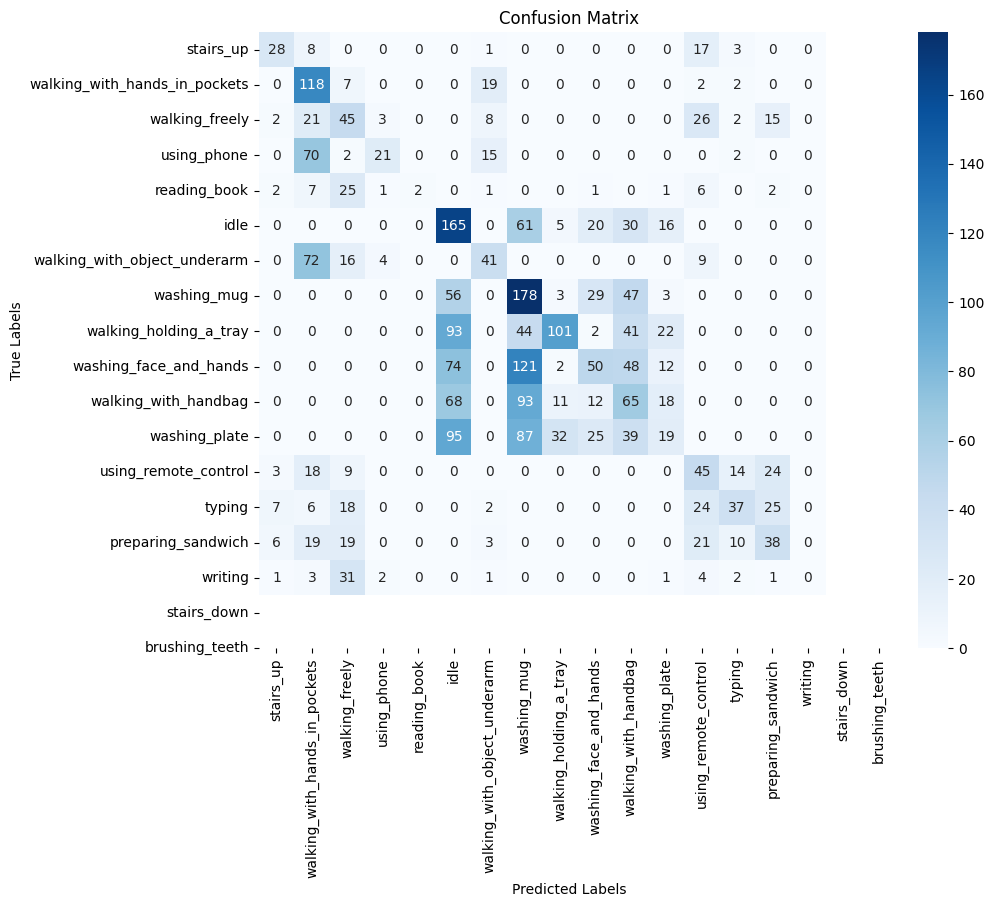

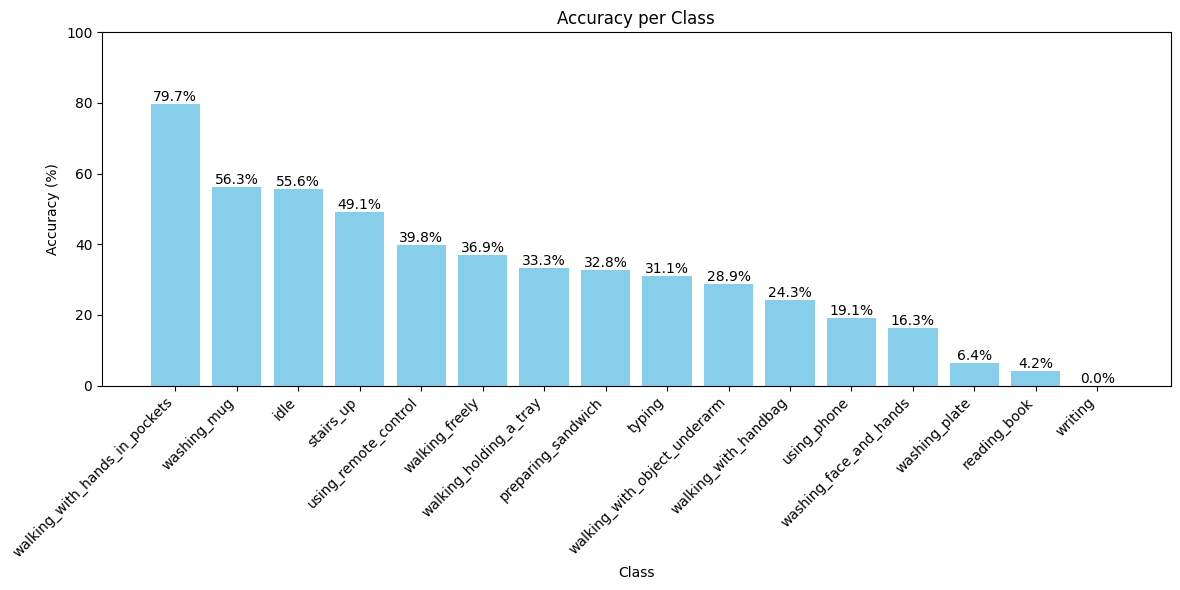

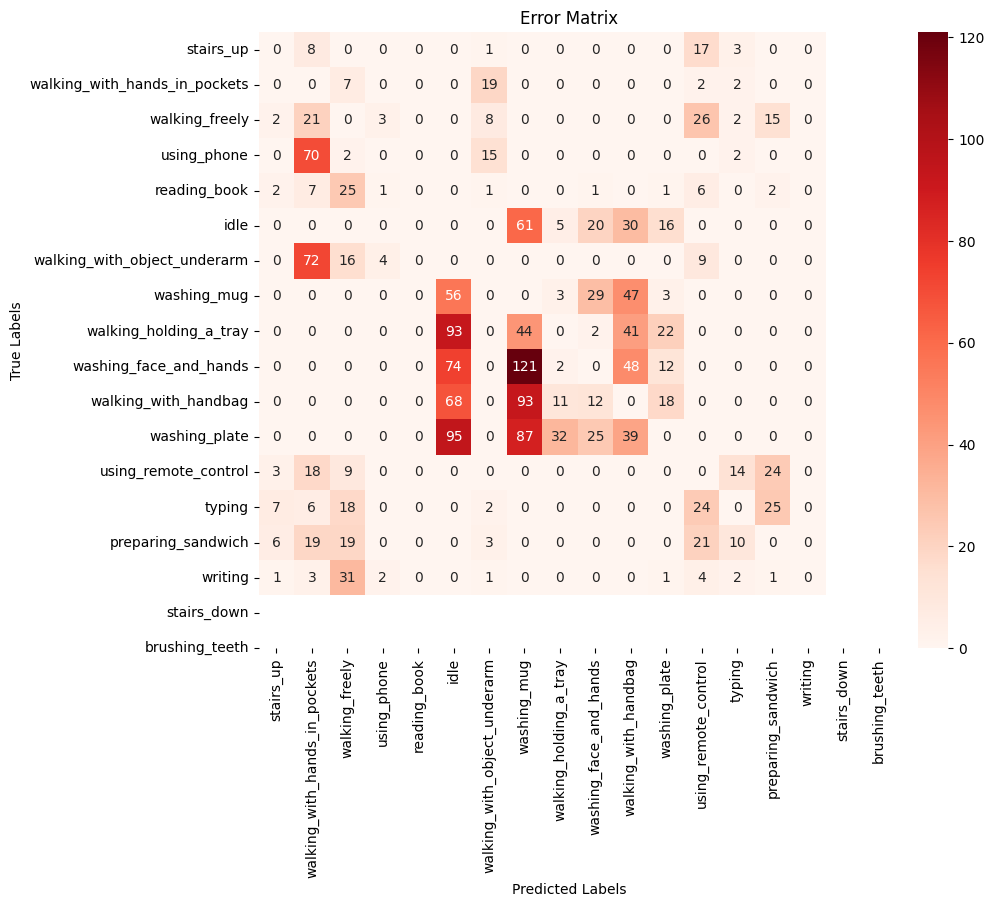

In [24]:
sequence_length = 300
num_features = 6
num_classes = len(np.unique(y_vicon_train))

cnn_vicon_model = SensorCNNModel(sequence_length, num_features, num_classes)

history = cnn_vicon_model.fit(X_vicon_train, y_vicon_train, X_val=X_vicon_val, y_val=y_vicon_val, epochs=10, batch_size=32)

val_vicon_accuracy = cnn_vicon_model.evaluate(X_vicon_val, y_vicon_val)
print(f"Validation Accuracy: {val_vicon_accuracy}")

predictions_vicon = cnn_vicon_model.predict(X_vicon_val)
print("Predictions for vicon:", predictions_vicon)

class_name = ['stairs_up','walking_with_hands_in_pockets', 'walking_freely', 'using_phone', 'reading_book', 'idle', 'walking_with_object_underarm', 'washing_mug', 'walking_holding_a_tray', 'washing_face_and_hands', 'walking_with_handbag', 'washing_plate', 'using_remote_control', 'typing', 'preparing_sandwich', 'writing', 'stairs_down', 'brushing_teeth']
cm = cnn_vicon_model.confusion_matrix(X_vicon_val, y_vicon_val, class_names=class_name)


# Connection between the models

226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Final Accuracy: 82.45%
Confusion Matrix:
[[199   1   4   0   0   0   0   2   0  17   0   2   0   0   2   0   3   2]
 [  3 342   0   1   0   0   0   1  11  26   1   1   0   0   0   0   1   0]
 [  6   0 250   0   0   0   0   1   0  33   0   4   0   1   7   1  26   0]
 [  0  13   2 340   0   0   0   0   7  23   0   3   0   0   1   1   0   0]
 [  0   1   0   0 201  12   0   0   0   6   0   8   0   0   0   0   0   1]
 [  0   0   0   0   0 246   0   0   0   3   0   0   0   2   0   0   0   0]
 [  0   3   0   0   0   0 158   1   0  14   0   4   0   0   0   1   0  11]
 [  1   0   0   0   0   0   0 436   0  98   0  23   0   7   2   0   1   0]
 [  2  13   1   2   0   0   0   0 308  35   0   2   0   0   2   0   0   3]
 [  0   1   0   0   0   3   0  14   0 505   0  67   1   6   0   0   0   0]
 [  0   3   0   0   0   0   1   0   2  10 563   3   0   2   0   1   0   0]
 [  0   1   0   0   0   0   0   6   0 130   0 449   1 

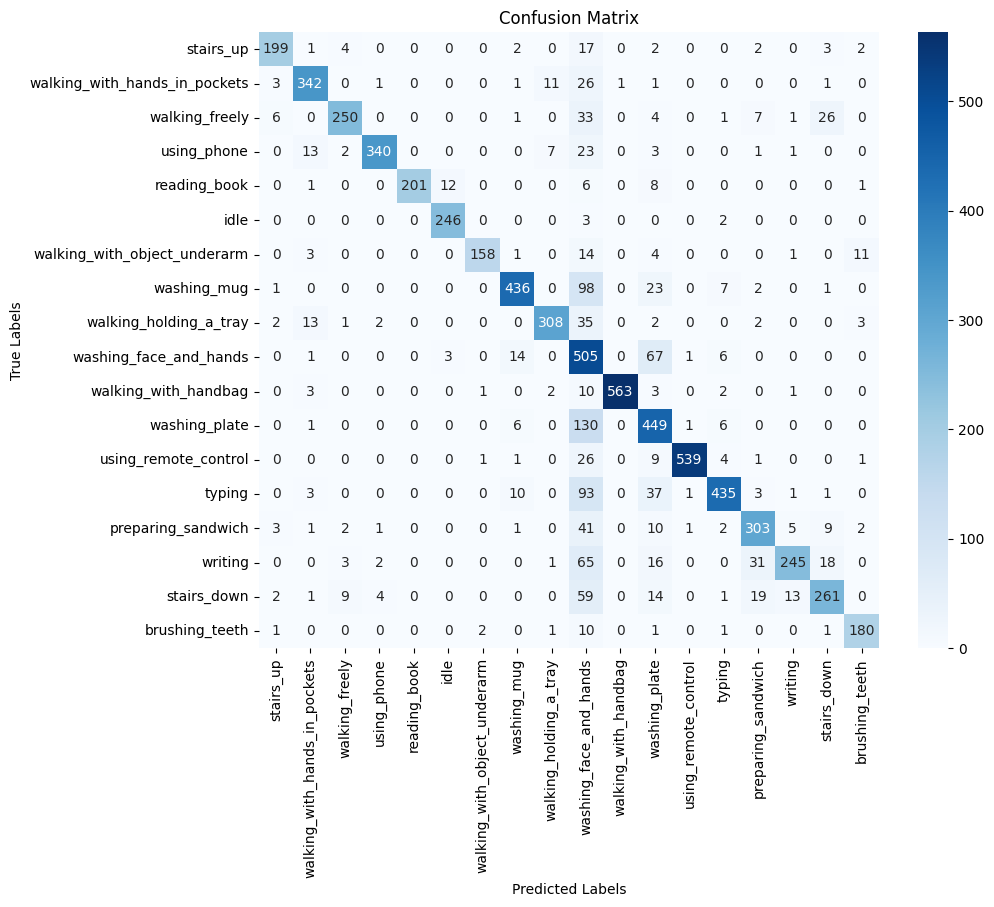

In [ ]:
def update_vicon_model(original_vicon_model, num_classes):
    model = models.Sequential()

    for layer in original_vicon_model.model.layers[:-1]:
        model.add(layer)

    model.add(layers.Dense(18, activation='softmax'))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

cnn_vicon_model_updated = update_vicon_model(cnn_vicon_model, 18)


predictions_smartwatch = cnn_smartwatch_model.predict(X_smartwatch_val)
predictions_vicon = cnn_vicon_model_updated.predict(X_vicon_val)

if len(predictions_smartwatch) > len(predictions_vicon):
    num_repeats = len(predictions_smartwatch) // len(predictions_vicon) + 1
    predictions_vicon = np.tile(predictions_vicon, (num_repeats, 1))[:len(predictions_smartwatch)]
elif len(predictions_vicon) > len(predictions_smartwatch):
    num_repeats = len(predictions_vicon) // len(predictions_smartwatch) + 1
    predictions_smartwatch = np.tile(predictions_smartwatch, (num_repeats, 1))[:len(predictions_vicon)]

combined_predictions = (predictions_smartwatch + predictions_vicon) / 2

final_predictions = np.argmax(combined_predictions, axis=1)

accuracy = accuracy_score(y_smartwatch_val, final_predictions)
print(f"Final Accuracy: {accuracy:.2%}")

cm = confusion_matrix(y_smartwatch_val, final_predictions)
print("Confusion Matrix:")
print(cm)

class_name = ['stairs_up','walking_with_hands_in_pockets', 'walking_freely', 'using_phone', 'reading_book', 'idle', 'walking_with_object_underarm', 'washing_mug', 'walking_holding_a_tray', 'washing_face_and_hands', 'walking_with_handbag', 'washing_plate', 'using_remote_control', 'typing', 'preparing_sandwich', 'writing', 'stairs_down', 'brushing_teeth']  # רשימה של השמות של הקטגוריות

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_name, yticklabels=class_name)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()



#LSTM

In [25]:
class SensorLSTMModel:
    def __init__(self, sequence_length, num_features, num_classes):
        self.sequence_length = sequence_length
        self.num_features = num_features
        self.num_classes = num_classes
        self.model = self._create_model()

    def _create_model(self):
        model = models.Sequential()

        model.add(layers.LSTM(64, input_shape=(self.sequence_length, self.num_features), return_sequences=True))
        model.add(layers.Dropout(0.2))

        model.add(layers.LSTM(64))
        model.add(layers.Dropout(0.2))

        model.add(layers.Dense(64, activation='relu'))
        model.add(layers.Dense(self.num_classes, activation='softmax'))

        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        return model

    def fit(self, X_train, y_train, X_val, y_val, epochs=10, batch_size=32):
        X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
        X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))

        history = self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val))
        return history

    def evaluate(self, X_val, y_val):
        X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
        val_loss, val_acc = self.model.evaluate(X_val, y_val)
        print(f"Validation Accuracy: {val_acc}")
        return val_acc

    def predict(self, X):
        X = X.reshape((X.shape[0], 1, X.shape[1]))
        predictions = self.model.predict(X)
        return predictions


    def confusion_matrix(self, X_val, y_val, class_names=None):
        # Ensure data has the correct shape
        X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))

        y_pred = np.argmax(self.model.predict(X_val), axis=1)

        cm = confusion_matrix(y_val, y_pred)

        accuracy = accuracy_score(y_val, y_pred)
        total_predictions = cm.sum()
        correct_predictions = np.trace(cm)
        incorrect_predictions = total_predictions - correct_predictions

        print(f"Accuracy: {accuracy:.2%}")
        print(f"Correct Predictions: {correct_predictions}")
        print(f"Incorrect Predictions: {incorrect_predictions}")

        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted Labels")
        plt.ylabel("True Labels")
        plt.show()

        class_accuracy = cm.diagonal() / cm.sum(axis=1)

        sorted_indices = np.argsort(class_accuracy)[::-1]
        sorted_class_names = [class_names[i] for i in sorted_indices]
        sorted_class_accuracy = class_accuracy[sorted_indices]

        plt.figure(figsize=(12, 6))
        bars = plt.bar(sorted_class_names, sorted_class_accuracy * 100, color='skyblue')

        for bar, acc in zip(bars, sorted_class_accuracy):
            plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{acc * 100:.1f}%",
                    ha='center', va='bottom', fontsize=10)

        plt.title("Accuracy per Class")
        plt.ylabel("Accuracy (%)")
        plt.xlabel("Class")
        plt.xticks(rotation=45, ha='right')
        plt.ylim(0, 100)
        plt.tight_layout()
        plt.show()

        error_matrix = cm - np.diagflat(cm.diagonal())
        plt.figure(figsize=(10, 8))
        sns.heatmap(error_matrix, annot=True, fmt='d', cmap='Reds', xticklabels=class_names, yticklabels=class_names)
        plt.title("Error Matrix")
        plt.xlabel("Predicted Labels")
        plt.ylabel("True Labels")
        plt.show()

        return cm, accuracy, correct_predictions, incorrect_predictions

# SmartWatch

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


905/905 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.3789 - loss: 1.8788 - val_accuracy: 0.6564 - val_loss: 0.9084
Epoch 2/10
905/905 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.6380 - loss: 0.9593 - val_accuracy: 0.7199 - val_loss: 0.7438
Epoch 3/10
905/905 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.6832 - loss: 0.8238 - val_accuracy: 0.7463 - val_loss: 0.6702
Epoch 4/10
905/905 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.7177 - loss: 0.7387 - val_accuracy: 0.7658 - val_loss: 0.6073
Epoch 5/10
905/905 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.7377 - loss: 0.6814 - val_accuracy: 0.7931 - val_loss: 0.5488
Epoch 6/10
905/905 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7535 - loss: 0.6322 - val_accuracy: 0.8110 - val_loss: 0.5042
Epoch 7/10
905/905 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.7725 - loss: 0.5882 - val_accuracy: 0.8160 - val_loss: 0.4841
Epoch 8/10
905/905 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.7828 - loss: 0.5626 - val_accuracy: 0.8204

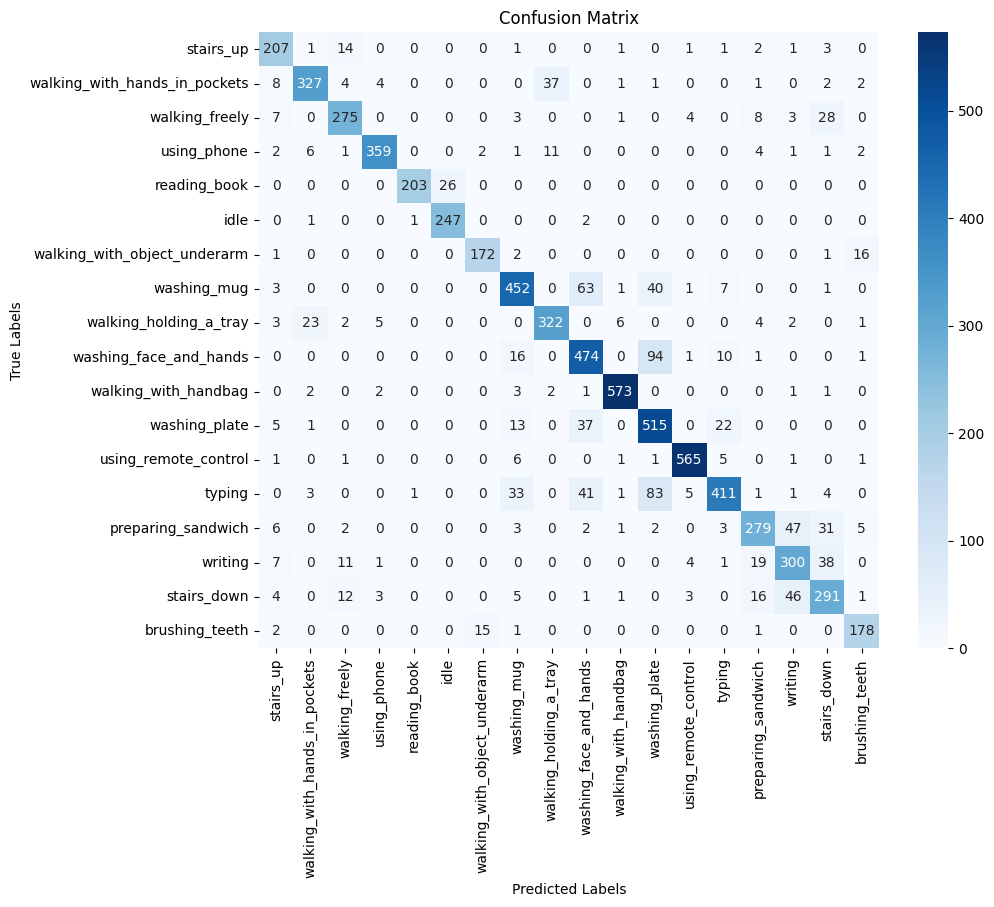

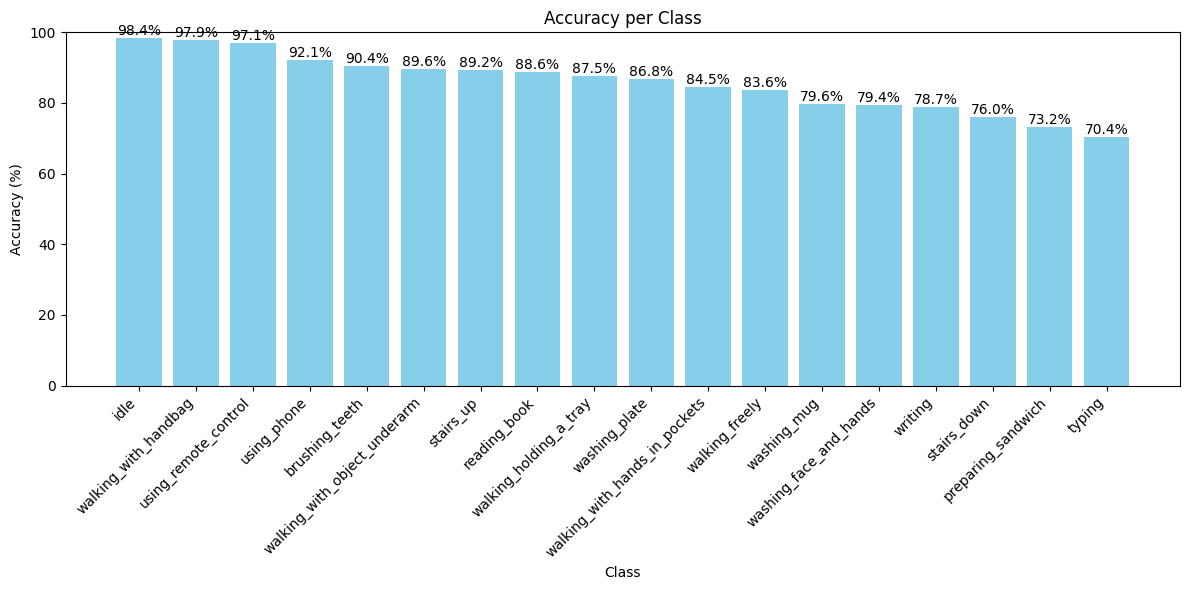

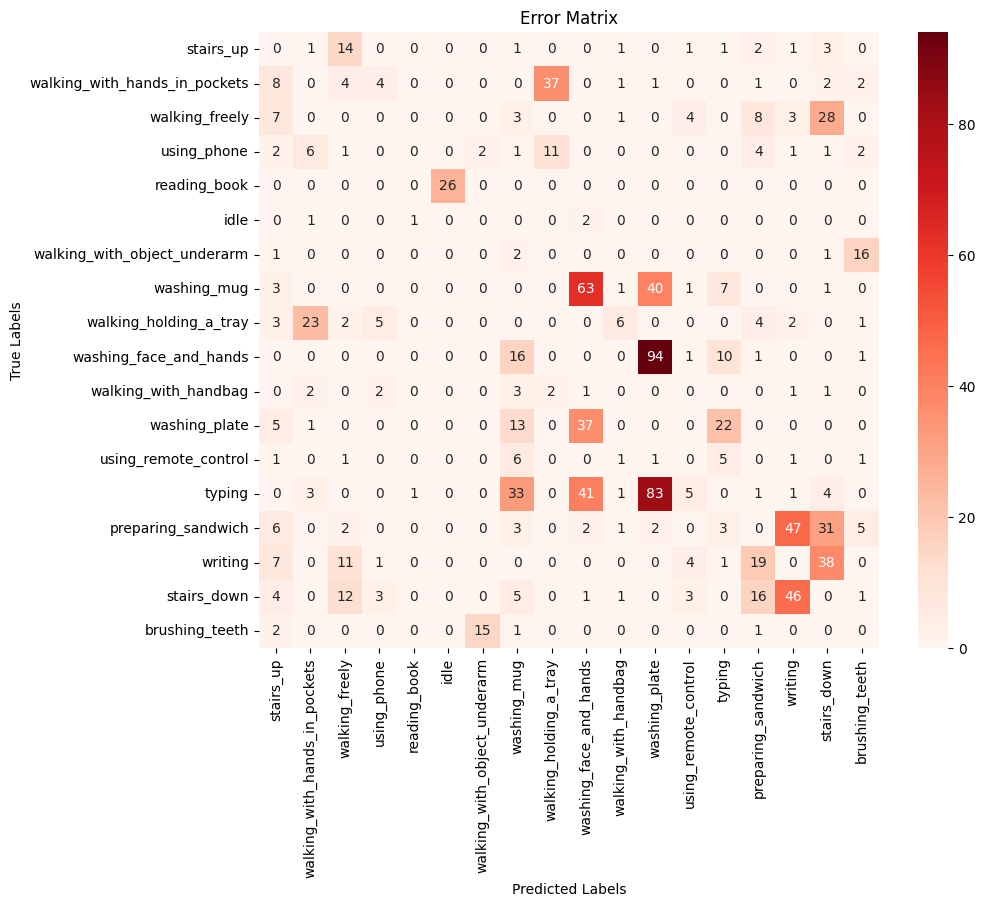

In [26]:
sequence_length = 3000
num_features = 18
num_classes = len(np.unique(y_smartwatch_train))

lstm_smartwatch_model = SensorLSTMModel(sequence_length, num_features, num_classes)

history_smartwatch = lstm_smartwatch_model.fit(X_smartwatch_train, y_smartwatch_train, X_val=X_smartwatch_val, y_val=y_smartwatch_val, epochs=10, batch_size=32)

val_smartwatch_accuracy = lstm_smartwatch_model.evaluate(X_smartwatch_val, y_smartwatch_val)
print(f"Validation Accuracy: {val_smartwatch_accuracy}")

predictions_smartwatch = lstm_smartwatch_model.predict(X_smartwatch_val)
print("Predictions:", predictions_smartwatch)
class_name = ['stairs_up','walking_with_hands_in_pockets', 'walking_freely', 'using_phone', 'reading_book', 'idle', 'walking_with_object_underarm', 'washing_mug', 'walking_holding_a_tray', 'washing_face_and_hands', 'walking_with_handbag', 'washing_plate', 'using_remote_control', 'typing', 'preparing_sandwich', 'writing', 'stairs_down', 'brushing_teeth']
cm = lstm_smartwatch_model.confusion_matrix(X_smartwatch_val, y_smartwatch_val, class_names=class_name)


# Vicon

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.1296 - loss: 2.4650 - val_accuracy: 0.1781 - val_loss: 1.9654
Epoch 2/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.1809 - loss: 1.9432 - val_accuracy: 0.2105 - val_loss: 1.8916
Epoch 3/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.1907 - loss: 1.8959 - val_accuracy: 0.2155 - val_loss: 1.8673
Epoch 4/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.2046 - loss: 1.8578 - val_accuracy: 0.2183 - val_loss: 1.8490
Epoch 5/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.2089 - loss: 1.8596 - val_accuracy: 0.2254 - val_loss: 1.8391
Epoch 6/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.2257 - loss: 1.8406 - val_accuracy: 0.2358 - val_loss: 1.8085
Epoch 7/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.2362 - loss: 1.8186 - val_accuracy: 0.2717 - val_loss: 1.7792
Epoch 8/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.2570 - loss: 1.7898 - val_accuracy: 0.

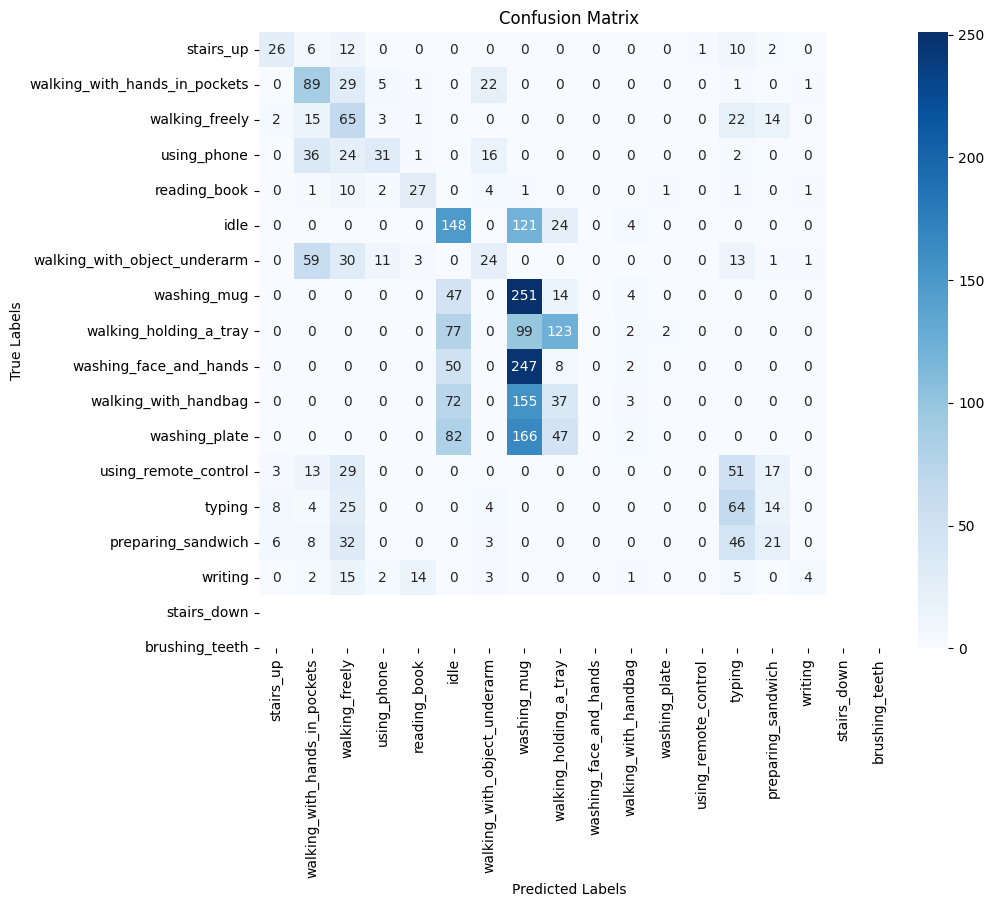

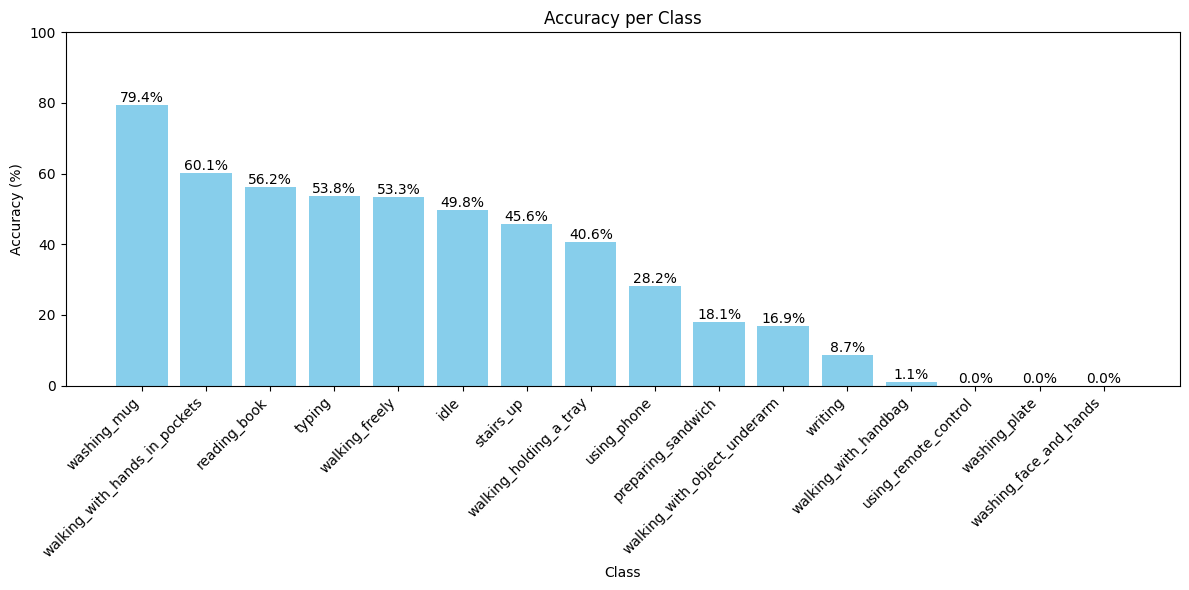

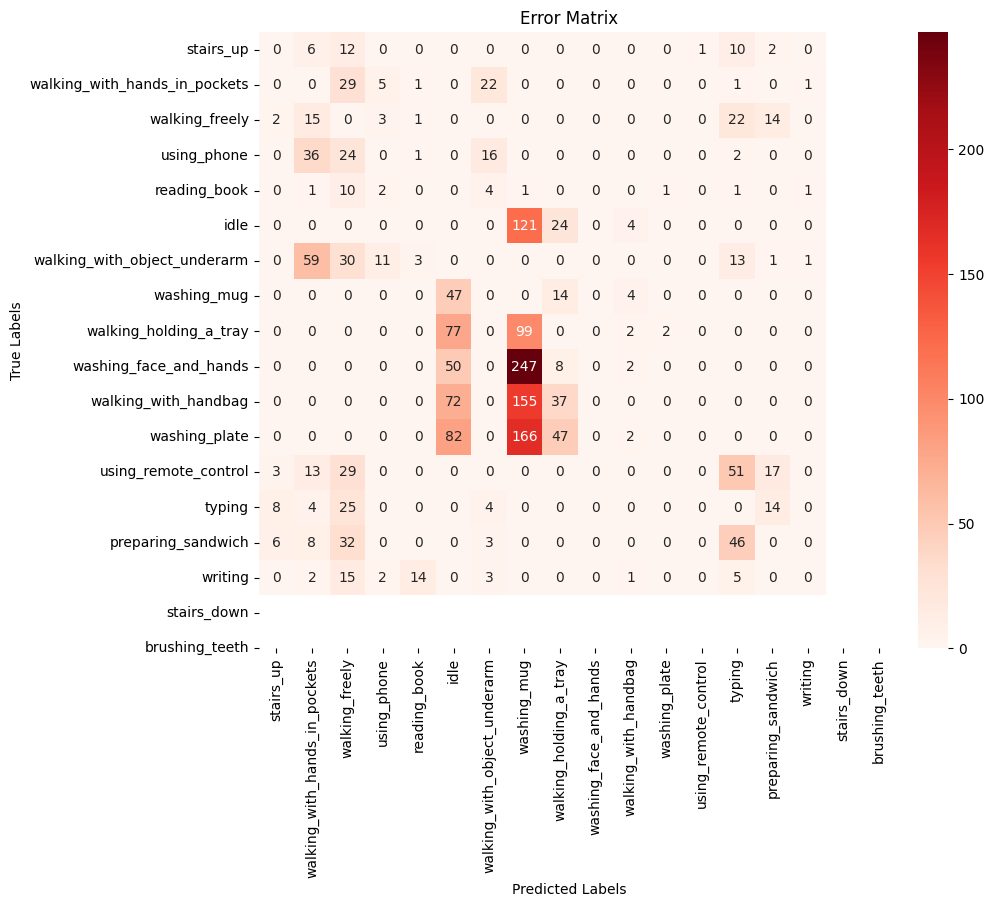

In [27]:
sequence_length = 3000
num_features = 6
num_classes = len(np.unique(y_smartwatch_train))

lstm_vicon_model = SensorLSTMModel(sequence_length, num_features, num_classes)

history_vicon = lstm_vicon_model.fit(X_vicon_train, y_vicon_train, X_val=X_vicon_val, y_val=y_vicon_val, epochs=10, batch_size=32)

val_vicon_accuracy = lstm_vicon_model.evaluate(X_vicon_val, y_vicon_val)
print(f"Validation Accuracy: {val_vicon_accuracy}")

predictions_vicon = lstm_vicon_model.predict(X_vicon_val)
print("Predictions:", predictions_vicon)
class_name = ['stairs_up','walking_with_hands_in_pockets', 'walking_freely', 'using_phone', 'reading_book', 'idle', 'walking_with_object_underarm', 'washing_mug', 'walking_holding_a_tray', 'washing_face_and_hands', 'walking_with_handbag', 'washing_plate', 'using_remote_control', 'typing', 'preparing_sandwich', 'writing', 'stairs_down', 'brushing_teeth']
cm = lstm_vicon_model.confusion_matrix(X_vicon_val, y_vicon_val, class_names=class_name)